# Normalizing Flows in Pytensor

A hip new algorithm for doing machine learning on distributions is called *normalizing flows*. 

The idea begins with the change of variables formula. We begin with a random variable $X \sim N(0, 1)$. Suppose we know the PDF for $X$ (because we do!). What if we instead wanted the PDF for $ Y = \exp(X)$. Do we know that? 

The answer is yes! We know it because of the *change of variable* formula, which states:

$$
g(y) = (f \circ G^{-1})(y) \left | \frac{\partial}{\partial x} G^{-1}(y) \right |
$$

Where:

- $g(\cdot)$ is the (unknown!) PDF of the variable $Y$
- $f(\cdot)$ if the (known!) PDF of the variable $X$
- $G(\cdot)$ is a function with nice properties.

The "nice properties" require (in the most general case) that $G(x)$ is a $C^1$ diffeomorphism, which means that it is 1) continuous and differentiable almost everywhere; 2) it is bijective, and 3) its derivaties are also bijective. 

A simpler requirement is that $G(x)$ is continuous, bijective, and monotonic. That will get us 99% of the way there. Hey, $\exp$ is continuous, bijective, and monotonic -- what a coincidence!


In [1]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt

import pytensor
import pytensor.tensor as pt
import pymc as pm

from pytensor.graph.basic import explicit_graph_inputs
from pytensor.graph.rewriting import rewrite_graph
from pytensor.graph.replace import vectorize_graph

/tmp/ipykernel_1045115/2831170013.py:9: RuntimeWarning: invalid value encountered in log
  G_inv = lambda x: np.where(x > 0, np.log(x), 0)


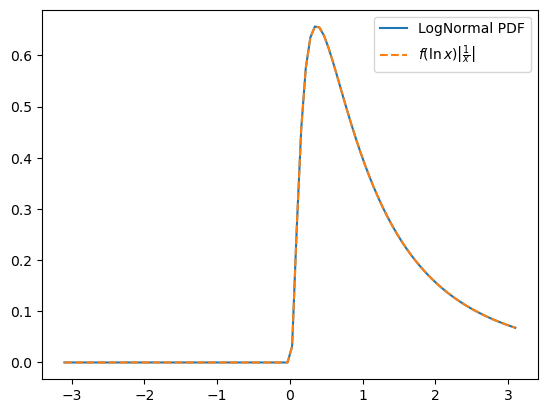

In [2]:

X = pz.Normal(0, 1)
Y = pz.LogNormal(0, 1)

x_grid = np.linspace(-3.1, 3.1, 100)

f_values = X.pdf(x_grid)

# I cheat a little bit by adding this where condition, setting the value to 0 if x <= 0
G_inv = lambda x: np.where(x > 0, np.log(x), 0)
d_G_inv = lambda x: np.where(x > 0, np.reciprocal(x), 0)
g_values = (X.pdf(G_inv(x_grid))) * np.abs(d_G_inv(x_grid))

fig, ax = plt.subplots()
ax.plot(x_grid, Y.pdf(x_grid), label='LogNormal PDF')
ax.plot(x_grid, g_values, ls='--', label=r'$f(\ln x) \left | \frac{1}{x} \right |$')
ax.legend()
plt.show()

This change of variables is basically all we need to understand normalizing flows. The logic goes like this:

1. Suppose we have some data $\mathcal{D} \sim D(\cdot)$, where $D$ is totally unknown.
2. We would like to sample from $D$, which seems hard since we don't know it.
3. Instead of sampling from $D$, let's instead sample $F(\cdot)$, where we get to choose $F$ to be as simple as possible. Say it's just $N(0, 1)$
4. Then, we'll use a change of variables to make draws from $F$ _look like_ draws from $D$. 
5. We just need a function $G(x)$ that makes *samples* $x \sim N(0, 1)$ look like our data.
6. $G$ needs to have the nice properties we want: monotonic, bijective, and invertible. And, we'd  like it to have some parameters to learn!

In [3]:
from abc import ABC
from pytensor.tensor.basic import TensorVariable

class Flow(ABC):
    __slots__ = ('parameters', )
    
    def transform(self, x: TensorVariable) -> TensorVariable:
        """Apply function F to the distribution x, along with the jacobian correction"""
        ...
        
    def inverse_transform(self, x: TensorVariable) -> TensorVariable:
        """Apply inverse function F^{-1} to the distribtuion x"""
        ...
        
class Exp(Flow):        
    def transform(self, x: TensorVariable) -> TensorVariable:
        return pt.exp(x)
        
    def inverse_transform(self, x: TensorVariable) -> TensorVariable:
        return pt.log(x)

class Affine(Flow):
    __slots__ = ('loc', 'scale', 'parameters')
    def __init__(self, loc=0, scale=1):
        self.loc = pt.as_tensor_variable(loc)
        self.scale = scale
        
    def transform(self, x):
        return self.loc + self.scale * x
    
    def inverse_transform(self, x):
        return (x - self.loc) / self.scale
        

In [4]:
def compose(*fns):
    def f(x):
        for f in fns:
            x = f(x)
        return x
    return f

rng = pytensor.shared(np.random.default_rng(), name='rng')
x = pt.random.normal(0, 1, rng=rng)

loc, scale = pt.dscalars('loc', 'scale')
transforms = [Affine(loc=loc, scale=scale), Exp()]
flow = compose(*[x.transform for x in transforms])

z = flow(x)

In [43]:
z.dprint()

Exp [id A]
 └─ Add [id B]
    ├─ loc [id C]
    └─ Mul [id D]
       ├─ scale [id E]
       └─ normal_rv{"(),()->()"}.1 [id F]
          ├─ rng [id G]
          ├─ NoneConst{None} [id H]
          ├─ 0 [id I]
          └─ 1 [id J]


In [5]:
z_values = pt.dvector('z_values')
z_logp = pm.logp(z, z_values, jacobian=True)
rewrite_graph(z_logp).dprint()

Switch [id A] 'z_values_logprob'
 ├─ Isnan [id B]
 │  └─ Mul [id C]
 │     ├─ [-1.] [id D]
 │     └─ Log [id E]
 │        └─ z_values [id F]
 ├─ [-inf] [id G]
 └─ Add [id H]
    ├─ Switch [id I]
    │  ├─ Isnan [id J]
    │  │  └─ Mul [id K]
    │  │     ├─ [-1.] [id D]
    │  │     └─ Log [id L]
    │  │        └─ Abs [id M]
    │  │           └─ Alloc [id N]
    │  │              ├─ scale [id O]
    │  │              └─ Squeeze{axis=0} [id P]
    │  │                 └─ Shape [id Q]
    │  │                    └─ Sub [id R]
    │  │                       ├─ Log [id E]
    │  │                       │  └─ ···
    │  │                       └─ ExpandDims{axis=0} [id S]
    │  │                          └─ loc [id T]
    │  ├─ [-inf] [id G]
    │  └─ Add [id U]
    │     ├─ Check{sigma > 0} [id V]
    │     │  ├─ Add [id W]
    │     │  │  ├─ [-0.91893853] [id X]
    │     │  │  └─ Mul [id Y]
    │     │  │     ├─ [-0.5] [id Z]
    │     │  │     └─ Pow [id BA]
    │     │  │        ├─ 

In [6]:
inputs = list(explicit_graph_inputs(z_logp))
inputs

[z_values, scale, loc]

In [7]:
z_values, scale, loc = inputs

In [8]:
f_logp_pymc = pytensor.function([z_values, loc, scale], z_logp)

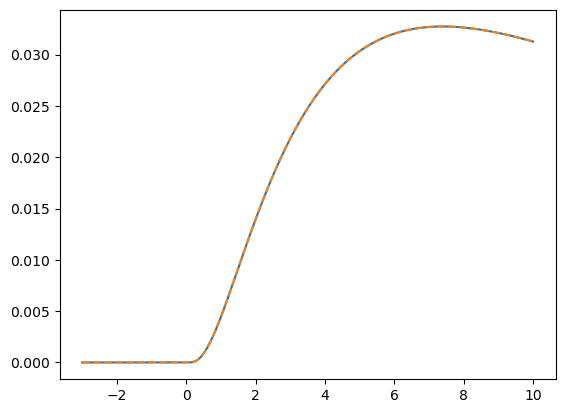

In [9]:
x_grid = np.linspace(-3, 10, 1000)
plt.plot(x_grid, np.exp(f_logp_pymc(z_values=x_grid, loc=3, scale=1.0)))
plt.plot(x_grid, pz.LogNormal(mu=3, sigma=1).pdf(x_grid), ls='--')

## Learn loc and scale

Suppose we just have samples from some "unknown" lognormal, we can learn parameters `loc` and `scale` by maximizing the log likelihood of the data

In [10]:
samples = pz.LogNormal(mu=2.234, sigma=0.99354).rvs(5000)

objective = -pm.logp(z, z_values, jacobian=True).mean()

grad_objective = pt.stack(pt.grad(objective, [loc, scale]))
f_obj_grad = pytensor.function([z_values, loc, scale], [objective, grad_objective])

# It would be nicer to just use the hessian function, but pytensor is fussy and doesn't like
# scalar inputs
hess = pt.stack(pytensor.gradient.jacobian(pt.stack(pt.grad(objective, [loc, scale])), [loc, scale]), axis=0)
f_hess = pytensor.function([z_values, loc, scale], hess)

f_sample = pm.compile([loc, scale], z)

In [11]:
from scipy.optimize import minimize

res = minimize(lambda x, *args: f_obj_grad(*args, *x),
         jac=True,
         hess=lambda x, *args: f_hess(*args ,*x),
         method='Newton-CG',
         x0=[0.8, 0.8],
         args=(samples, ),
         tol=1e-12)
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.6513115408067502
       x: [ 2.250e+00  9.830e-01]
     nit: 10
     jac: [-3.986e-13 -8.841e-12]
    nfev: 12
    njev: 12
    nhev: 10

<Axes: >

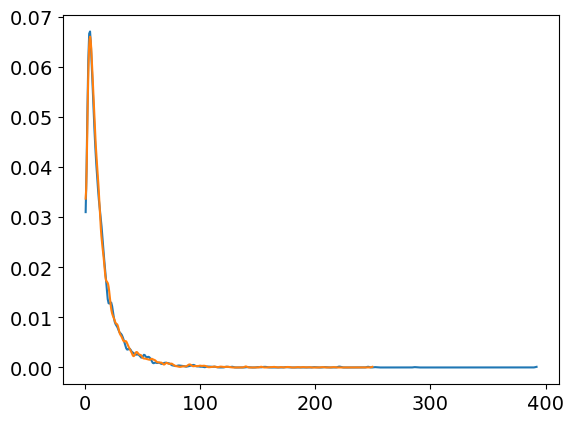

In [12]:
import arviz as az
az.plot_kde(np.r_[*[f_sample(*res.x) for _ in range(5000)]], plot_kwargs={'c':'tab:blue'})
az.plot_kde(samples, plot_kwargs={'c':'tab:orange'})


# Reproducing what PyMC does

Most of the heavy lifting here was done by PyMC. It already knows how to handle the change-of-variables formula for a wide variety of functions, including $\exp$ and affine shifts. That's why things just sort of magically worked up until now. 

Recall the formula for change of variables:

$$
g(x) = (f \circ G^{-1})(x) \left | \frac{\partial}{\partial x} G^{-1}(x) \right |
$$

Right now in the graph of $z$, we just have draws from $x$, passed through the function $G$. Or:

$$
z = G(x) 
$$

To get to where we want to go, we need to:

1. Iterate backwards over all the flows, applying the inverse function to the incoming samples
2. At the same time, we also need to compute $\left | \frac{\partial}{\partial x} G^{-1}(x) \right | $ and accumulate their products
3. We need to get the logp of the original random variable, $f(x)$, and plug in the result of (1) as the value
4. Finally, add the log of the product of the determinant corrections. 

Since in the end we need the log of the determinant, it will be easier to modify step (2) to accumulate the sum of the log determinant of the transformations

## In detail

We have two transformations, $H(x) = \exp(x)$ and $J(x) = a + bx$. Define $G$ as their composition, $G \equiv (H \circ J)(x) = \exp(a + bx)$

For inverses, we have $H^{-1}(x) = \ln(x)$ and $J^{-1}(x) = \frac{x - a}{b}$

So, the inverse of their composition is $G^{-1} \equiv (J^{-1} \circ H^{-1}) = J^{-1}(H^{-1}(x)) = J^{-1}(\ln(x)) = \frac{\ln(x) - a}{b}$

For the correction term, we need the determinant of the jacobian. Since $G$ is a scalar function, this is just the absolutel value of the gradient:

$$\left | \frac{\partial}{\partial x}G^{-1} \right | = \left | \frac{\partial}{\partial x} \frac{\ln(x) - a}{b} \right | = \left | \frac{1}{b} \cdot \frac{1}{x} \right | $$

We we will compute $g(z) = f(\frac{\ln(z) - a}{b}) \left | \frac{1}{b} \cdot \frac{1}{z} \right |$, where $f(x) = \frac{1}{\sqrt{2\pi}}\exp(-\frac{x^2}{2})$ is a standard normal PDF.

Of course we'll work with the logp, so we will actually have:

$$\ln g(z) = -\frac{1}{2}\ln{\sqrt{2\pi}} - \frac{1}{2}\left (\frac{\ln z - a}{b} \right )^2 - \ln{\left | b \right |} - \ln{\left | z \right |}$$

In [13]:
def standard_normal_logp(x):
    x = pt.as_tensor_variable(x)
    
    kernel = -x ** 2 / 2
    normalizing_constant = -0.5 * pt.log(2 * np.pi)
    return normalizing_constant + kernel

In [14]:
# Solution by hand
loc, scale = transforms[0].loc, transforms[0].scale
z_star = (pt.log(z_values) - loc) / scale
analytic = standard_normal_logp(z_star) - pt.log(pt.abs(scale)) - pt.log(pt.abs(z_values))
f_analytic = pytensor.function([z_values, loc, scale], analytic)

In [15]:
f_analytic(samples, loc=3, scale=1)

array([-3.49457579, -4.51443877, -4.06600535, ..., -3.95145566,
       -5.38270846, -3.42280756])

In [16]:
pz.LogNormal(mu=3, sigma=1).logpdf(samples)

array([-3.49457579, -4.51443877, -4.06600535, ..., -3.95145566,
       -5.38270846, -3.42280756])

Now we do it again using autodiff. We need the absolute value of the gradient through the whole composite transformation. We do it on a dummy scalar $x$, then vectorize back up to `z_values`, since that's the behavior we want.

We could also do `pt.grad(f_inverse(z_values).sum(), z_values)`, and rely on the fact that the sum function introduces no cross-terms in the gradient expression. This would be the same, but would require you to grok this math fact. I also like that the vectorize way shows off `vectorize_graph` again :)

In [46]:
list(explicit_graph_inputs(inverse_flow))

[z_values, loc, scale]

In [17]:
x = pt.dscalar('x')
inverse_flows = [f.inverse_transform for f in reversed(transforms)]

f_inverse = compose(*inverse_flows)
log_jac_det = pt.log(pt.abs(pt.grad(f_inverse(x), x)))
log_jac_det = vectorize_graph(log_jac_det, {x:z_values})

inverse_flow = standard_normal_logp(f_inverse(z_values)) + log_jac_det
f_logp_flow = pytensor.function(list(explicit_graph_inputs(inverse_flow)), inverse_flow)

In [18]:
f_logp_flow(samples, loc=3, scale=1)

array([-3.49457579, -4.51443877, -4.06600535, ..., -3.95145566,
       -5.38270846, -3.42280756])

In [19]:
f_logp_pymc(samples, loc=3, scale=1)

array([-3.49457579, -4.51443877, -4.06600535, ..., -3.95145566,
       -5.38270846, -3.42280756])

## Re-do optimization using our new implementation

In [20]:
objective = -inverse_flow.mean()

grad_objective = pt.stack(pt.grad(objective, [loc, scale]))
f_obj_grad = pytensor.function([z_values, loc, scale], [objective, grad_objective])

hess = pt.stack(pytensor.gradient.jacobian(pt.stack(pt.grad(objective, [loc, scale])), [loc, scale]), axis=0)
f_hess = pytensor.function([z_values, loc, scale], hess)

In [21]:
res = minimize(lambda x, *args: f_obj_grad(*args, *x),
         jac=True,
         hess=lambda x, *args: f_hess(*args, *x),
         method='Newton-CG',
         x0=[0.8, 0.8],
         args=(samples,),
         tol=1e-12)
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.6513115408067502
       x: [ 2.250e+00  9.830e-01]
     nit: 10
     jac: [-3.986e-13 -8.840e-12]
    nfev: 12
    njev: 12
    nhev: 10

# Something more powerful

Now that we see how this whole change of variables thing works, we can step up the complexity. Let's look at a 2d example, and learn some flow parameters to generate draws from a half-moon distribution.

I don't know what the logp for a 2d half-moon distribution is, but we can try to learn it! We will still use the Affine transformation, but we can introduce more complexity by parameterizing the location and scale parameters with.... dun dun dun! Deep Neural Networks (what else?)

You have to be somewhat clever about the type of transformation you do with the network, though, because the jacobian has to remain tractible. A *coupling layer* is the simplest type of normalizing flow I could find in time to prepare this notebook. Given a $D$ dimensional input $x$, we're going to partition it at $d < D$, then define the output as:

$$
\begin{align}
y_{0:d} &= x_{0:d} \\
y_{d:D} &= x_{d:D} \odot \exp \left ( \sigma(x_{0:d}) \right ) + \mu(x_{0:d})
\end{align}
$$

Where $\sigma(x)$ is a "scale function" and $\mu(x)$ is a "location function". Basically the idea is this. We take in a vector of input features. We divide the vector in two: the input part ($x_{0:d}$) and the update part ($x_{d:D}$). We use the input part as input to neural networks $\sigma(\cdot)$ and $\mu(\cdot)$, which will then update the update part. The input part is passed along without change.

The reason for choosing this scheme is that the jacobian becomes:


$$
\frac{\partial y}{\partial x^T} = \begin{bmatrix} I_d & 0 \\ \frac{\partial y_{d:D}}{\partial x_{0:d}^T} & \text{Diag}(\exp(\sigma(x_{0:d})) \end{bmatrix}
$$

Why is this great? Because it's lower triangular (see that lovely $0$ in the top-right, plus two triangular matrices in the upper left and lower right), which means the determinant of this thing is just the product of the diagonal! Since the upper left corner is a bunch of ones, it just boils down to $\prod \exp(\sigma(x_{0:d}) = \exp \left (\sum \sigma(x_{0:d}) \right )$, which doesn't even depend on the network $\sigma(\cdot)$ really, just it's outputs. So this is super cheap to work with!

In [22]:
from pytensor_ml.layers import Linear, Sequential
from pytensor_ml.activations import LeakyReLU
from pytensor_ml.model import Model

In [23]:
from itertools import pairwise
def make_mlp(name, input_shape, hidden_shapes): 
    all_shapes = [input_shape, *hidden_shapes]
    layers = []

    for i, (n_in, n_out) in enumerate(pairwise(all_shapes)):
        layers.append(Linear(name=f'{name}_{i+1}', n_in=n_in, n_out=n_out))
        layers.append(LeakyReLU())
    
    return Sequential(*layers)

class Coupling(Flow):
    
    def __init__(self, 
                 name,
                 input_shape, 
                 hidden_shapes: list[int] | None = None, 
                 flip_x=False):
        
        self.flip_x = flip_x
        self.input_shape = input_shape
        self.d = input_shape // 2
        self.feature_extractor = make_mlp(name=f'{name}_feature_extractor',
                                          input_shape=self.d, 
                                          hidden_shapes=hidden_shapes)
        self.scale_network = Sequential(self.feature_extractor,
                                   Linear(name=f'{name}_scale_output', 
                                          n_in=hidden_shapes[-1], 
                                          n_out=self.d))
        self.loc_network = Sequential(self.feature_extractor,
                                      Linear(name=f'{name}_loc_output', 
                                             n_in=hidden_shapes[-1], 
                                             n_out=self.d))

    def transform_and_log_det(self, x):
        if self.flip_x:
            x = pt.flip(x, axis=1)
            
        d = self.d
        x_cond, x_trans = x[..., :d], x[..., d:]
        
        loc = self.loc_network(x_cond)
        log_scale = self.scale_network(x_cond)
        
        transformer = Affine(loc=loc, scale=pt.exp(log_scale))
        
        x_trans = transformer.transform(x_trans)
        log_det = pt.abs(log_scale).sum(axis=1)
        
        x = pt.join(-1, x_cond, x_trans)
        
        if self.flip_x:
            x = pt.flip(x, axis=1)
            
        return x, log_det
    
    def inverse_transform_and_log_det(self, x):
        if self.flip_x:
            x = pt.flip(x, axis=1)
            
        d = self.d
        x_cond, y_trans = x[..., :d], x[..., d:]
        
        loc = self.loc_network(x_cond)
        log_scale = self.scale_network(x_cond)
        
        scale = pytensor.printing.Print('scale')(log_scale)
        
        transformer = Affine(loc=loc, scale=pt.exp(log_scale))
        
        x_trans = transformer.inverse_transform(y_trans)
        
        log_det = -pt.abs(log_scale).sum(axis=1)
        x = pt.join(-1, x_cond, x_trans)
        
        if self.flip_x:
            x = pt.flip(x, axis=1)            
            
        return x, log_det

In [24]:
n_flows = 12
transformers = [Coupling(f'coupling_{i}', input_shape=2, hidden_shapes=(64, 64), flip_x=(i % 2)) 
                for i in range(n_flows)]

def transform_samples_to_latent(x, transformers):
    log_det_acc = 0

    for trans in reversed(transformers):
        x, log_det = trans.inverse_transform_and_log_det(x)
        log_det_acc += log_det
        
    return x, log_det_acc

def transform_latent_to_samples(x, transformers):
    for trans in transformers:
        x, _ = trans.transform_and_log_det(x)
    return x

x_values = pt.tensor('x_values', shape=(None, 2))
z_values, log_det = transform_samples_to_latent(x_values, transformers)

logp = standard_normal_logp(z_values).sum(axis=-1) + log_det

In [25]:
z_in = pt.tensor('z_in', shape=(None, 2))
x_out = transform_latent_to_samples(z_in, transformers)
f_forward = pytensor.function([z_in, *list(filter(lambda x: x is not z_in, explicit_graph_inputs(x_out)))],
                              x_out,
                              mode='NUMBA')

In [35]:
model = Model(X=x_values, y=z_values)
model.initialize_weights(scheme='xavier_normal')

optimizer_weights = [param.type() for param in model.weights]

weight_names = [x.name for x in model.weights]
weight_dict = dict(zip(weight_names, model.weight_values))

In [27]:
obj = rewrite_graph(-logp.mean(), include=('canonicalize', 'stabilize'))
lr = pt.dscalar('learning_rate')

weight_grads = pt.grad(obj, model.weights)
new_weights = [weight - lr * grad for weight, grad in zip(model.weights, weight_grads)]

In [28]:
f_step = pytensor.function([x_values, lr, *model.weights], 
                           [obj, *new_weights],
                           mode='NUMBA')

In [29]:
f_backward = pytensor.function([x_values, *model.weights],
                               z_values,
                               mode='NUMBA')

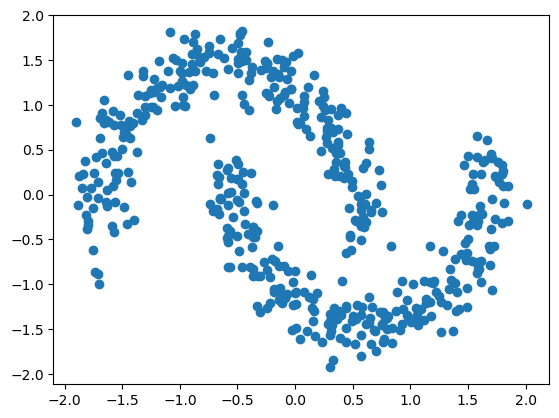

In [30]:
from sklearn.datasets import make_moons
X, _ = make_moons(n_samples=500, noise=0.1)
X = (X - X.mean(axis=0)) / X.std(axis=0)

plt.scatter(*X.T)

In [36]:
X[:2]

array([[-1.46655435,  0.67158506],
       [-0.21262665,  1.30925525]])

In [37]:
f_backward(X[:2], **weight_dict)

array([[  1.54823459, -11.56647097],
       [  3.67169466,  -9.35211768]])

In [38]:
f_forward(f_backward(X[:2], **weight_dict), **weight_dict)

array([[-1.46655435,  0.67158506],
       [-0.21262665,  1.30925525]])

In [39]:
from tqdm.notebook import tqdm

n_iter = 10_000
batch_size = 300

model.initialize_weights(scheme='xavier_uniform')
weight_dict = dict(zip(weight_names, model.weight_values))
n_weights = len(model.weight_values)    
loss_history = np.empty(n_iter)
idx = np.arange(X.shape[0])

for t in tqdm(range(n_iter)):
    np.random.shuffle(idx)
    loss_val, *new_weights = f_step(X[idx[:batch_size]], 3e-4, **weight_dict)
    
    if np.isnan(loss_val):
        break
    weight_dict.update(dict(zip(weight_names, new_weights)))
    loss_history[t] = loss_val

  0%|          | 0/10000 [00:00<?, ?it/s]

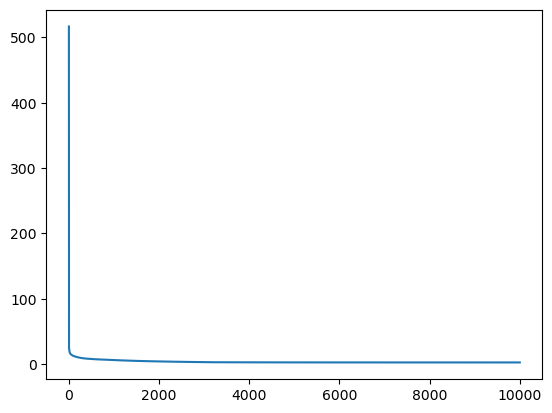

In [40]:
plt.plot(loss_history)

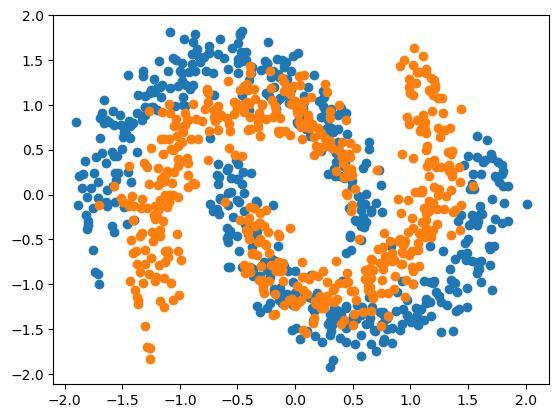

In [41]:
plt.scatter(*X.T)
plt.scatter(*f_backward(X, **weight_dict).T)
# plt.scatter(*f_forward(f_backward(X, **weight_dict), **weight_dict).T)

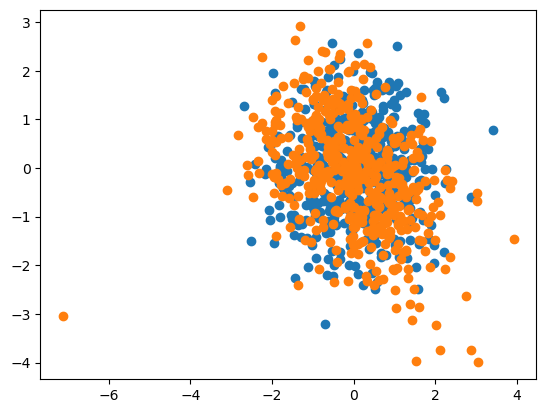

In [42]:
draws = np.random.normal(size=(500, 2))
fig, ax = plt.subplots()
ax.scatter(*draws.T)
ax.scatter(*f_forward(draws, **weight_dict).T)